In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/CompPhys/MD/COOR

/content/drive/My Drive/Colab Notebooks/CompPhys/MD/COOR


In [ ]:
pwd 

'/content/drive/My Drive/Colab Notebooks/CompPhys/MD/COOR'

In [ ]:
%load_ext cython 

In [ ]:
%%cython
from cython.view cimport array as cvarray
import numpy as np 
cimport numpy as np 
from libc.math cimport sqrt,ceil
#from scipy.spatial.distance import squareform,pdist
from numpy import array
import scipy as scipy
from scipy import optimize
from scipy.constants import k as kb
import pandas as pd

np.random.seed(10)

cpdef timestep():
  global U
  
  data[:,0]+=data[:,2]*h+0.5*data[:,4]*(h**2)
  data[:,1]+=data[:,3]*h+0.5*data[:,5]*(h**2)

  data[:,2]+=0.5*data[:,4]*h
  data[:,3]+=0.5*data[:,5]*h
  
  U=U_a(data,N,r_c)

  data[:,2]+=0.5*data[:,4]*h
  data[:,3]+=0.5*data[:,5]*h
  
  cross_r=data[:,0]>L
  cross_l=data[:,0]<0
  cross_t=data[:,1]>L
  cross_b=data[:,1]<0
  
  data[cross_r,0]=0
  data[cross_l,0]=L
  data[cross_t,1]=0
  data[cross_b,1]=L

  #data[cross_r|cross_l,2]*=-1
  #data[cross_t|cross_b,3]*=-1

cpdef initialize(int N,float L,int d,float v):

  data=np.zeros((N,d*3),dtype='double')
  cdef int N_x=int(sqrt(N/2))
  cdef int N_y=int(ceil(N/N_x))
  
  x = np.linspace(1,(L/2), N_x)
  y = np.linspace(r_c,L-r_c, N_y)
  xv, yv = np.meshgrid(x,y)

  data[:,0]=np.reshape(xv,np.shape(xv)[0]*np.shape(xv)[1])[:N]
  data[:,1]=np.reshape(yv,np.shape(xv)[0]*np.shape(yv)[1])[:N]
  data[:,2:4]=(2*np.random.rand(N,2)-1)*v
  v_renormalize(data,N)

  return data

cpdef v_renormalize(data,int N):
  v_com_x=np.mean(data[:,2])
  v_com_y=np.mean(data[:,3])
  data[:,2]-=v_com_x
  data[:,3]-=v_com_y

cpdef K(data):
  v_2=(data[:,2]**2)+ (data[:,3]**2)
  velocities[counter]=array(data[:,2:4])
  #velocities[counter]=v_2
  return np.sum(1/2*(v_2))

cpdef double U_a(data,int N,float r_c):
  global virial

  x_mat=array([data[:,0]-i for i in data[:,0]])
  x_mat[x_mat>L/2]-=L
  x_mat[x_mat<-L/2]+=L

  y_mat=array(([data[:,1]-i for i in data[:,1]]))
  y_mat[y_mat>L/2]-=L
  y_mat[y_mat<-L/2]+=L
  
  r_mat=(x_mat**2)+(y_mat**2)
  #unique_distances=np.triu(r_mat)
  
  ind1,ind2=np.where(r_mat<=(r_c**2))
  unique=(ind1<ind2)
  ind1=ind1[unique]
  ind2=ind2[unique]
  #ind1,ind2=np.where((r_mat>0 & (r_mat<(r_c**2))))
  #print(np.sqrt(unique_distances[ind1,ind2]))
  
  a_x=np.zeros((N,N),dtype=np.dtype('d'))
  a_y=np.zeros((N,N),dtype=np.dtype('d'))

  cdef double U_temp=0
  cdef double r_2,r_6,r_12,const

  for i1,i2 in zip(ind1,ind2):
    
    r_2=r_mat[i1,i2]
    r_6=r_2*r_2*r_2
    r_12=r_6*r_6
    const=(4*((12/r_12)-(6/r_6)))/r_2
    
    a_x[i1,i2]=const*x_mat[i1,i2]
    a_x[i2,i1]=-a_x[i1,i2]
    
    a_y[i1,i2]=const*y_mat[i1,i2]
    a_y[i2,i1]=-a_y[i1,i2]
    
    U_temp+=(1/r_12)-(1/r_6)

  data[:,4]=np.sum(a_x,axis=0)
  data[:,5]=np.sum(a_y,axis=0)
  
  if t%sampling==0:
    virial[counter]= (1/2)*np.sum(a_x*x_mat+a_y*y_mat)
  
  return 4*U_temp 
  
cpdef correlation():
  global corr,velocities
  length=np.shape(corr)[0]
  velocities=array(velocities)
  cdef int i,k,j
  for i in range(int(length)):
    for k in range(N):
      u=velocities[:,k,:]
      corr_temp=0
      for j in range(length-i):
        corr_temp+=np.sum(u[j,:]*u[j+i,:])
      corr[i]+=(corr_temp/(length-i))
  corr/=N
  corr/=corr[0]
    
cpdef exponential(x, a, k, b):
  return a*np.exp(x*k) + b 

cdef int N=100 #number of particles
cdef int d=2 #dimension
cdef double m=6.7*10.0**(-26) #particle mass in Kg
cdef double sigma=3.4*10.0**(-10) #sigma constant in m
cdef double epsilon=1.6*10.0**(-21) #epsilon constant in J
cdef double tau=sqrt((m*sigma*sigma)/epsilon) #Characteristic time
cdef double simulation_time=(2*10.0**(-10)) #simulation time in seconds
cdef float L=3*int(sqrt(N)) #length of the box in reduced units  
cdef float h=10.0**(-3) #delta t 
cdef int steps_number=int(simulation_time/(tau*h)) #number of steps for the entire simulation 
cdef int sampling=100
cdef float r_c=3
virial=np.zeros(int(steps_number//sampling)+1,dtype=np.dtype('d'))

v_max=4
v_step=0.9
data=initialize(N,L,d,v_max)



#data=initialize(N,L,d,temp_list[-1])
#U=U_a(data,N,r_c)

cdef int counter,t,u=1

df=pd.DataFrame(columns=['E','T','P'])
mean_temprature=200
while mean_temprature>=160:
  
  E=np.zeros(int(steps_number//sampling)+1,dtype=np.dtype('d')) #energy list
  K_list=np.zeros(int(steps_number//sampling)+1,dtype=np.dtype('d')) #kinetic energy list 
  velocities=[0]*(int(steps_number//sampling)+1)
  corr=np.zeros(int(len(velocities)/3),dtype=np.dtype('d'))
  
  counter=0


  for t in range(steps_number):
    timestep()
    if t%sampling==0:
      K_list[counter]=K(data)
      E[counter]=K_list[counter]+U
      counter+=1
  
  correlation()

  x_array=array(range(0,np.shape(corr)[0]))
  popt_exponential,_= scipy.optimize.curve_fit(exponential, x_array,corr, p0=[1,-0.5, 1])
  relax_time=int(ceil(-1/popt_exponential[1]))
  mean_temprature=np.mean(((K_list*1.6*10.0**(-21))/((N-1)*kb))[relax_time:])
  pressure=np.mean(((N*kb*mean_temprature-(1/2)*virial*1.6*10.0**(-21))/(L*L*sigma*sigma))[relax_time:])
  Energy=np.mean(E[relax_time:])

  df.loc[u]=[Energy,mean_temprature,pressure] 
  print(mean_temprature)
  if mean_temprature<93 and mean_temprature>80:
    data[:,2:4]*=0.99
  else:
    data[:,2:4]*=v_step
  v_renormalize(data,N)
  u+=1

df.to_csv('van der waals.csv')
print('finish')


from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')



564.9825719972783
460.77714351969513
373.3458486548852
303.14102841113527
248.5652265571593
202.6414968554389
166.53304147141694
139.0657825454309
finish


# Temprature vs Energy

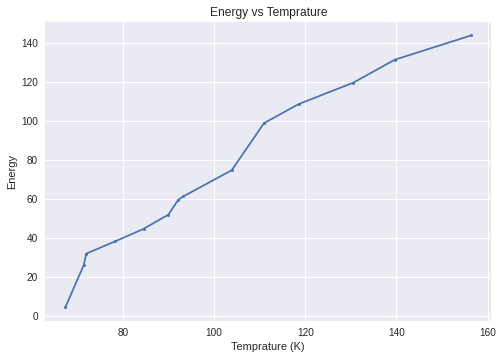

In [ ]:
import scipy as scipy
from scipy import optimize
plt.style.use('seaborn')
def linear(x,a,b):
  return a*x+b 
df=pd.read_csv('phase.csv')
E=np.array(df['E'].to_list())
T=np.array(df['T'].to_list())

E=np.sort(E)
T=np.sort(T)


plt.plot(T,E,'-o',ms=3)
plt.xlabel('Temprature (K)')
plt.ylabel('Energy')
plt.title('Energy vs Temprature')
plt.savefig('phase.png')

# Pressure vs Temprature

[1.09916611e-05 3.43080029e-04]


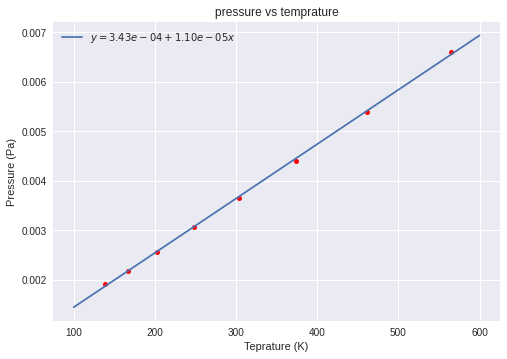

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd 

df=pd.read_csv('van der waals.csv')
P=df['P'].to_list()
T=df['T'].to_list()
coeff=np.polyfit(T,P,1)
print(coeff)
plt.plot(T,P,'ro',ms=5)
x=np.linspace(100,600)
plt.plot(x,coeff[0]*x+coeff[1],label='$y=%.2e+%.2ex$'%(coeff[1],coeff[0]))
plt.xlabel('Teprature (K)')
plt.ylabel('Pressure (Pa)')
plt.title('pressure vs temprature')
plt.legend()
plt.savefig('van.png')